# Software analytics: Increase code review speed — impact on global colaboration in large projects

## Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

https://zenodo.org/records/3922907

In [52]:
def load_data():
    data = pd.read_csv('./data/new_pullreq.csv', header=0)
    return data
data = load_data()
data

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,Kronos-Integration,kronos-service-consul,1,9,9.0,1,0,0,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,saltstack,salt,0,1165,NaN,1,10,0,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,mjmlio,mjml,1,8834,8834.0,2,6,0,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,zotonic,zotonic,0,703,NaN,7,15,0,...,0,0,0,0,10.0,0,0.000732,0,703,0


## Overview of data

Number of projects: 11230


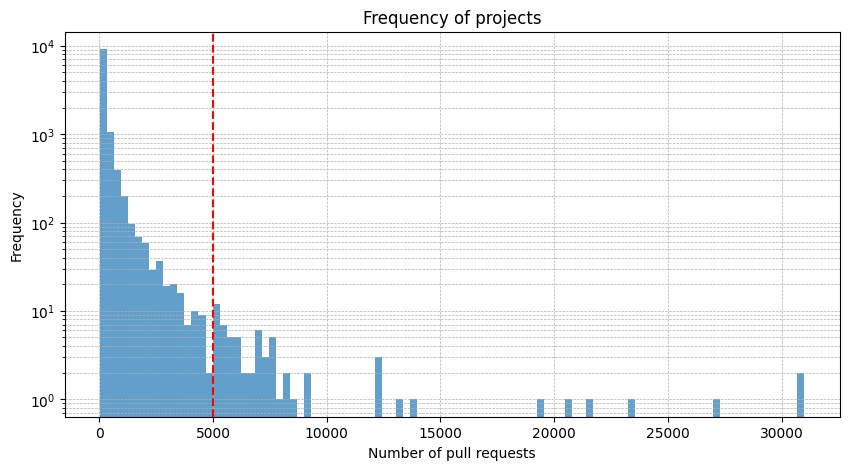

Number of project with more than 5000 pull requests: 64


In [92]:
num_projects = data['project_id'].unique()
print('Number of projects: {}'.format(len(num_projects)))

projects = data['project_id'].value_counts()
project_ids = projects.index
num_pull_requests = projects.values

plt.figure(figsize=(10, 5))
plt.hist(num_pull_requests, bins=100, alpha=0.7, log=True)
plt.axvline(x=5000, color='r', linestyle='--')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Frequency of projects')
plt.xlabel('Number of pull requests')
plt.ylabel('Frequency')
plt.show()

print('Number of project with more than 5000 pull requests: {}'.format(len(projects[num_pull_requests > 5000])))
filtered_project_ids_pr = projects[num_pull_requests > 5000].index

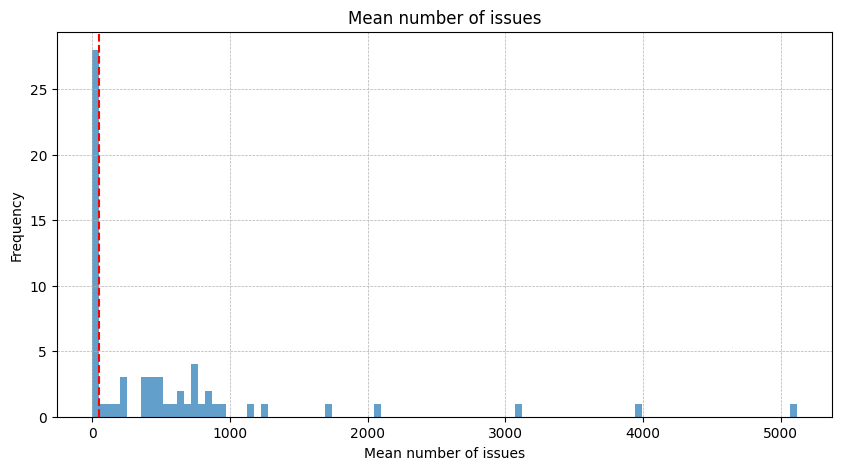

Number of project with more than 50 issues: 36


In [100]:
opened_issues = data[data['project_id'].isin(filtered_project_ids_pr)].groupby('project_id')['open_issue_num'].mean()

plt.figure(figsize=(10, 5))
plt.hist(opened_issues, bins=100, alpha=0.7)
plt.axvline(x=50, color='r', linestyle='--')
plt.xlabel('Mean number of issues')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of issues')
plt.show()

filtered_project_ids_issue = opened_issues[opened_issues > 50].index
print('Number of project with more than 50 issues: {}'.format(len(filtered_project_ids_issue)))

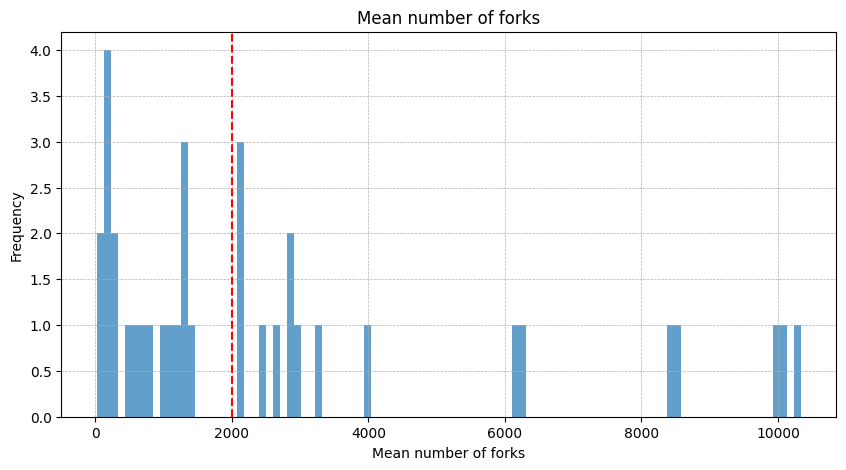

Number of project with more than 2000 forks: 17


In [103]:
forks = data[data['project_id'].isin(filtered_project_ids_issue)].groupby('project_id')['fork_num'].mean()
plt.figure(figsize=(10, 5))
plt.hist(forks, bins=100, alpha=0.7)
plt.axvline(x=2000, color='r', linestyle='--')
plt.xlabel('Mean number of forks')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of forks')
plt.show()

filtered_project_ids_forks = forks[forks > 2000].index
print('Number of project with more than 2000 forks: {}'.format(len(filtered_project_ids_forks)))

In [104]:
print(data[data['project_id'].isin(filtered_project_ids_forks)]['reponame'].unique())

['scikit-learn' 'salt' 'metasploit-framework' 'kubernetes' 'react' 'node'
 'ansible' 'playframework' 'odoo' 'three.js' 'rails' 'matplotlib'
 'ember.js' 'pandas' 'mastodon' 'gatsby' 'spree']
